# Building a US Treasury Spot Yield Curve

The Treasury spot yield curve is the risk-free dollar spot/zero interest rate as a function of maturity. It is the interest rate that one could achieve on an investment that begins today and is locked in until maturity, paying zero coupons inbetween. For some maturities these can be observed directly in the market as zero-coupon bonds (T-bills are quoted out to 1 year). For longer maturities coupon-paying Notes and Bonds must be used to compute the implied zero rate.

All of the data used has been collected from the Wall Street Journal [[1](https://www.wsj.com/market-data/bonds/treasuries)] and reflect the closing prices on **Friday 5th July 2019**.

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as optimize
from scipy import interpolate
import matplotlib.pyplot as plt

today = np.datetime64('2019-07-05')

In [2]:
billsPath = "Bills_07-05-19.csv"
notesBondsPath = "Notes_Bonds_07-05-19.csv"

billData = pd.read_csv(billsPath, index_col = 'MATURITY', parse_dates = True)
bondData = pd.read_csv(notesBondsPath, index_col = 'MATURITY', parse_dates = True)

billData.head()

,BID,ASKED,CHG,ASKED YIELD
MATURITY,,,,
2019-07-09,2.173,2.163,-0.035,2.1990
2019-07-11,2.178,2.168,-0.012,2.1980
2019-07-16,2.215,2.205,-0.005,2.2430
2019-07-18,2.210,2.200,0.02,2.2320
2019-07-23,2.205,2.195,-0.012,2.2336


In [3]:
bondData.head()

,COUPON,BID,ASKED,CHG,ASKED YIELD
MATURITY,,,,,
2019-07-15,0.750,99.310,99.314,0.01,1.559
2019-07-31,0.875,99.290,99.294,0.008,2.108
2019-07-31,1.375,99.300,99.304,0.01,2.111
2019-07-31,1.625,99.304,99.310,0.008,2.112
2019-08-15,0.750,99.270,99.274,0.01,2.095


#### Bills

Treasury Bills are quoted at their discount from the par or face value of the contract. For example, consider the T-Bill maturing on 5th December 2019 seen below.

The bid annualised discount rate is 2.048%. This needs to be scaled to account for the remaining number of days until expiry. Specifically, the number of days between the settlement date and the maturity date. Since T-Bills can settle on the same day that they're traded, this is 153. Lastly, noting that the daycount convention for Treasuries is [Actual/Actual] the price for this Bill can be computed as 99.14%.

Bills are typically traded with a face value of \$1 million. Thus an investor could buy the 5th December 2019 Bill for \$991,400 and receive $1 million at maturity.

In [23]:
bill = billData.loc['2019-12-05']
print(bill)

BID            2.048
ASKED          2.038
CHG            0.025
ASKED YIELD    2.084
Name: 2019-12-05 00:00:00, dtype: object


In [24]:
def computeBillPrice(today, maturity, discountRate):    
    numDaysToMaturity = ( (maturity - today) / np.timedelta64(1,'D') ).astype(int)
    
    price = 100*(1 - (numDaysToMaturity / 365)*(discountRate/100) )
        
    return price

In [25]:
maturity = np.datetime64('2019-12-05')

price = computeBillPrice(today, maturity, bill['BID'])

print(price)

99.1415232877


#### Notes & Bonds

Treasury Notes and Bonds are perhaps quoted more intuitively, but still only their *clean* price is displayed. That is, the price does not account for interest that has accrued to the owner since the last coupon was received. For example, consider the T-Note maturing on 15th September 2020 seen below.

This Note pays a semi-annual coupon at 1.375% of face value. Its last coupon date (which must be a business day) has been computed to be 18th March 2019, whilst its next coupon date is 16th September 2019. The accrued interest is then computed between the last coupon date and the settlement date. Notes and Bonds settle on T+1, which in this example will roll forward to the next business day: Mon 8th July. The price for this Note is therefore 99.51%

Notes and Bonds are also typically traded with a face value of \$1 million. Thus an investor could buy the 15th September 2020 Note for \$995,100. She would receive the following cash flows:

- 16th September 2019: $\quad$ \$6875
- 16th March 2020:     $\qquad$ \$6875
- 15th September 2020: $\quad$ \$6875 + \$1,000,000

In [8]:
note = bondData.loc['2020-09-15']
print(note)

COUPON          1.375
BID             99.09
ASKED          99.094
CHG            -0.034
ASKED YIELD     1.976
Name: 2020-09-15 00:00:00, dtype: object


In [9]:
def computeDirtyBondPrice(today, maturity, cleanPrice, annualisedCouponRate):
        
    lastCouponDate = getLastCouponDate(today, maturity)

    nextCouponDate = lastCouponDate + pd.Timedelta(6, unit='M')
    nextCouponDate = np.busday_offset(nextCouponDate, 0, roll='forward')
    
    numDaysInThisPeriod = (nextCouponDate - lastCouponDate).astype(int)
    
    settleDate = np.busday_offset(today, 1, roll='forward')
    
    numDaysSinceLastCoupon = (settleDate - lastCouponDate).astype(int)
    
    accruedInterestRate = (numDaysSinceLastCoupon / numDaysInThisPeriod)*(annualisedCouponRate/2)
    
    dirtyPrice = cleanPrice + accruedInterestRate
    
    return dirtyPrice

def getLastCouponDate(today, maturity):
    
    lastCouponDate = maturity

    while( lastCouponDate > today ):
        lastCouponDate -= pd.Timedelta(6, unit='M')
    
    lastCouponDate = np.busday_offset(lastCouponDate, 0, roll='forward')

    #incase rolling to the next business day pushes lastCouponDate ahead of today
    if( lastCouponDate > today ):
        lastCouponDate -= pd.Timedelta(6, unit='M')
        
    lastCouponDate = np.busday_offset(lastCouponDate, 0, roll='forward')
    
    return lastCouponDate

In [10]:
maturity = np.datetime64('2020-09-15')

dirtyPrice = computeDirtyBondPrice(today, maturity, note['BID'], note['COUPON'])
print(dirtyPrice)

99.5130769231


## Filtering the data

The better the quality of our data, the more accurate and useful our spot yield curve will be. We want to pick liquid instruments that are in-line with the rest of the market and whose prices reflect their true value, not animal spirits or some market dislocation induced by regulatory requirements. It is well known that the most recently issued bond at each maturity (the *on-the-runs*) are the most liquid, whereby their initial prices should be very close to par.

I have selected 11 instruments whose dirty price is very close to par, attempting to span the entire set of maturities out to 30 years. This becomes more difficult for longer maturities for two reasons. One is that 30 year T-Bond auctions were cancelled between 2001 and 2006, resulting in a sparsity of bonds maturing between 2031-2036. Secondly, after trading on the secondary market for such a long amount of time, longer maturity bonds are rarely close to par.

In [11]:
def getFilteredBondData():
    
    bondMaturityToIndexMap = {'2020-07-31': 1,  '2021-01-31': 0,  '2021-08-31': 1, '2022-04-30': 1, 
                              '2023-01-31': 0,  '2024-04-30': 0,  '2025-08-15': 0, '2026-06-30': -1,
                              '2029-05-15': -1, '2045-02-15': -1, '2046-05-15': -1}

    cols = ["Maturity", "Coupon", "Dirty Bid", "Dirty Bid YTM", "Maturity [Years]"]
    filteredBondData = pd.DataFrame( np.zeros((len(bondMaturityToIndexMap), len(cols))) , columns = cols)

    i=0

    for (maturity, index) in bondMaturityToIndexMap.items():
        if( index == -1):
            bond = bondData.loc[maturity]
        else:
            bond = bondData.loc[maturity].iloc[index]

        dirtyBid = computeDirtyBondPrice(today, np.datetime64(maturity), bond['BID'], bond['COUPON'])
        filteredBondData.iloc[i] = [maturity, bond['COUPON'], dirtyBid, 0, 0]
        i += 1
        
    return filteredBondData

In [12]:
getFilteredBondData()

,Maturity,Coupon,Dirty Bid,Dirty Bid YTM,Maturity [Years]
0,2020-07-31,2.000,100.873626,0.0,0.0
1,2021-01-31,1.375,99.632841,0.0,0.0
2,2021-08-31,2.000,100.788791,0.0,0.0
3,2022-04-30,1.875,100.381426,0.0,0.0
4,2023-01-31,1.750,99.991615,0.0,0.0
5,2024-04-30,2.000,100.601121,0.0,0.0
6,2025-08-15,2.000,100.976703,0.0,0.0
7,2026-06-30,1.875,99.242058,0.0,0.0
8,2029-05-15,2.375,102.652335,0.0,0.0
9,2045-02-15,2.500,100.074143,0.0,0.0


## Par Yield Curve

This curve plots *yield to maturity* (YTM) of bonds trading at par as a function of maturity. The YTM (or *internal rate of return*) of a bond is the discount rate that, when applied to all of its cash flows, gives a present value that is equal to its market price.

Take, for example, the T-Note maturing on 15th September 2020 considered previously. It has a semi-annual coupon of 1.375% and is trading in the market with a dirty bid price of 99.51. Noting its cash flows shown above, its YTM is the value of $y$ that solves the following equation

$ 99.5130769231 = 0.6875 e^{-(70/365)y/100} + 0.6875 e^{-(252/365)y/100} + 0.6875 e^{-(435/365)y/100} + 100 e^{-(435/365)y/100}$

YTM has its limitations as a measure of value, as it assumes that you will hold the bond until maturity and are able to reinvest all of the coupons as soon as you receive them at the continuously compounded YTM rate.

The function *computeYTM()* below determines the yield to maturity of this bond to be 2.14%

In [13]:
def PV(today, maturity, annualisedCouponRate, ytm):
    
    couponDayCounts = []
    
    lastCouponDate = getLastCouponDate(today, maturity)
    
    nextCouponDate = lastCouponDate + pd.Timedelta(6, unit='M')
    nextCouponDate = np.busday_offset(nextCouponDate, 0, roll='forward')
    
    settleDate = np.busday_offset(today, 1, roll='forward')
    
    numDaysInThisPeriod = ( (nextCouponDate - settleDate) /np.timedelta64(1,'D') ).astype(int)
    
    while( nextCouponDate < maturity ):
        couponDayCounts.append(numDaysInThisPeriod)
        lastCouponDate = nextCouponDate
        nextCouponDate = lastCouponDate + pd.Timedelta(6, unit='M')
        nextCouponDate = np.busday_offset(nextCouponDate, 0, roll='forward')
        numDaysInThisPeriod = ( (nextCouponDate - lastCouponDate) / np.timedelta64(1,'D') ).astype(int)
        
    #do this to ensure that the last coupon period reaches all the way up until the maturity date
    numDaysBetweenLastCouponDateAndMaturity = ( (maturity - lastCouponDate) / np.timedelta64(1,'D') ).astype(int)
    couponDayCounts[-1] += numDaysBetweenLastCouponDateAndMaturity
    cumulativeDayCounts = np.cumsum(couponDayCounts)
    
    pv = 0
    for days in cumulativeDayCounts:
        pv += (annualisedCouponRate/2) * np.exp(-(days/365)*(ytm/100))
        
    pv += 100 * np.exp(-(cumulativeDayCounts[-1]/365)*(ytm/100))
    
    return pv

def computeYTM(today, maturity, annualisedCouponRate, price):
    
    #YTM is the root of this function
    def rootSolveFunction(ytm):
        return PV(today, maturity, annualisedCouponRate, ytm) - price
    
    #the couponRate is a good initial guess for the YTM
    result = optimize.root( rootSolveFunction, [annualisedCouponRate] )
    
    return result.x[0]

In [14]:
maturity = np.datetime64('2020-09-15')

ytm = computeYTM(today, maturity, 1.375, 99.5130769231)
print(ytm)

2.14089237336


Using this function we can compute the YTM for each of our selected instruments based on their dirty bid price. This will be the raw data used to determine our par yield curve.

In [15]:
def getParYieldData():
    
    parData = getFilteredBondData()
    
    for index, row in parData.iterrows():
        parData.loc[index, "Dirty Bid YTM"] = computeYTM(today, 
                                                         np.datetime64(row['Maturity']),
                                                         row['Coupon'],
                                                         row['Dirty Bid'])
        
        parData.loc[index, "Maturity [Years]"]  = (np.datetime64(row['Maturity']) - today) / np.timedelta64(365,'D')        
    
    return parData

def PlotRawParYieldCurve():
    
    parData = getParYieldData()
    
    plt.plot(parData["Maturity [Years]"], parData["Dirty Bid YTM"], 'o')
    
    plt.style.use(['bmh'])
    plt.suptitle("Raw Par Yield Curve for selected US Treasuries", fontsize=16)
    plt.xlabel("Maturity [Years]")
    plt.ylabel("Yield To Maturity")
    plt.show()

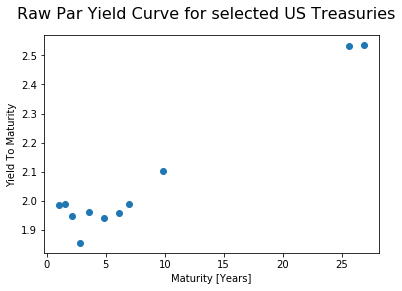

In [16]:
PlotRawParYieldCurve()

We will now interpolate these data with a cubic spline in order to build a robust, continuous curve.

In [17]:
def splineParYieldCurve( maturityArray ):
    
    parData = getParYieldData()
    
    maturities = parData["Maturity [Years]"]
    ytm = parData["Dirty Bid YTM"]
    
    tck = interpolate.splrep(maturities, ytm, k=3)
    return interpolate.splev(maturityArray, tck)

def PlotParYieldCurve():
    
    maturities = [0.5*n for n in range(2, 61)]
    interpolatedYields = splineParYieldCurve( maturities )  
    
    plt.plot(maturities, interpolatedYields, label="spline")
    
    parData = getParYieldData()
    plt.plot(parData["Maturity [Years]"], parData["Dirty Bid YTM"], 'o', label = "raw data")
    
    plt.legend()
    plt.style.use(['bmh'])
    plt.suptitle("Par Yield Curve for US Treasuries", fontsize=16)
    plt.xlabel("Maturity [Years]")
    plt.ylabel("Yield To Maturity [continuously compounded]")
    plt.show()

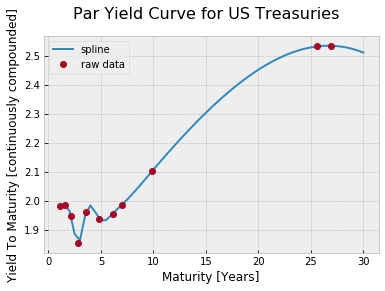

In [18]:
PlotParYieldCurve()

The Par Yield curve is not used that often in the secondary market, since it is rare for instruments to be trading at par. Note that for bonds trading at par, the yield to maturity is exactly equal to the coupon. For this reason the Par Yield curve is often used in the primary market to determine the coupon that should be offered on a new bond issued to the market at par.

This convenient mathematical fact, that for bonds trading at par the yield to maturity is equal to the coupon, will come in handy later.

## Constructing the Spot Yield Curve

#### Short End

As mentioned previously, spot interest rates for maturities less than one year can be observed directly in the market thanks to zero-coupon T-Bills.

For example, consider again the T-Bill maturing on 5th December 2019. It has a price of 99.14 and 153 days until maturity, at which point the face value will be received.

Where $r$ is the annual continuously compounded interest rate, this can be represented by the equation:

$99.14 = 100e^{-(153/365)r} \implies r = 2.06\%$

We can calculate this for each of our T-Bill quotes and plot the short end of the continuously compounded spot yield curve.

In [26]:
def computeSpotRate(today, maturity, price):
    numDaysToMaturity = ( (maturity - today) / np.timedelta64(1,'D') ).astype(int)
    
    spotRate = (365/numDaysToMaturity) * np.log(100/price)
    
    return 100*spotRate

def getShortEndData():
    
    cols = ['Maturity', 'Dirty Bid', 'Spot Rate', 'Maturity [Years]']
    shortEndData = pd.DataFrame( np.zeros((len(billData), len(cols))) , columns = cols)

    i=0
    for index, row in billData.iterrows():
        maturity = index.to_datetime64()
        maturityInYears = (maturity - today) / np.timedelta64(365,'D')
        dirtyPrice = computeBillPrice(today, maturity, row['BID'])

        shortEndData.iloc[i] = [index, dirtyPrice, computeSpotRate(today, maturity, dirtyPrice), maturityInYears]
        i += 1
    
    return shortEndData

def PlotRawShortSpotYieldCurve():
    
    shortEndData = getShortEndData()
    
    plt.plot(shortEndData["Maturity [Years]"], shortEndData["Spot Rate"], 'o')
    
    plt.style.use(['bmh'])
    plt.suptitle("Raw Short End Spot Yield Curve for US Treasuries", fontsize=16)
    plt.xlabel("Maturity [Years]")
    plt.ylabel("Spot Rate [continuously compounded]")
    plt.show()

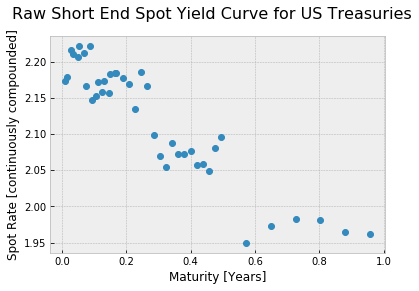

In [27]:
PlotRawShortSpotYieldCurve()

We will fit a quartic polynomial to these points in order to produce a continuous short end curve.

In [28]:
def fittedShortSpotCurve( maturityArray ):
    shortEndData = getShortEndData()
    
    model = np.polyfit(shortEndData["Maturity [Years]"], shortEndData["Spot Rate"], 4)
    modelFunc = np.poly1d( model )
    
    return modelFunc( maturityArray )

def PlotShortSpotYieldCurve():
    
    maturities = [0.05*n for n in range(0, 21)]
    modelSpots = fittedShortSpotCurve( maturities )
    
    plt.plot(maturities, modelSpots, label="quartic model")
    
    shortEndData = getShortEndData()
    plt.plot(shortEndData["Maturity [Years]"], shortEndData["Spot Rate"], 'o', label = "raw data")
    
    plt.legend()
    plt.style.use(['bmh'])
    plt.suptitle("Short End Spot Yield Curve for US Treasuries", fontsize=16)
    plt.xlabel("Maturity [Years]")
    plt.ylabel("Spot Rate [continuously compounded]")
    plt.show()

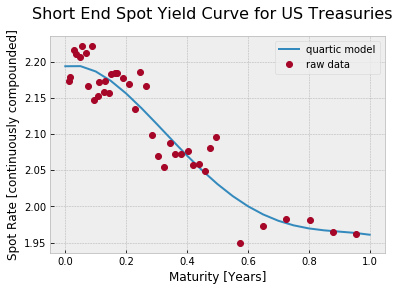

In [29]:
PlotShortSpotYieldCurve()

Now for a carefully chosen set of maturities, we will use the Par Yield and Short End Spot Yield curve to construct a set of instruments that we cannot observe directly in the market. Here we are making explicit use of the mathematical fact that for bonds on the Par Yield curve, their coupon is equal to their yield to maturity.

In [32]:
def getSpotCurveRawData():

    cols = ['Maturity', 'Maturity [Years]', 'Coupon', 'Spot Rate']
    maturitiesYears = [0.25] + [0.5*n for n in range(1,61)]
    maturities = [(today + pd.Timedelta(3, unit='M')).normalize().to_datetime64()]
    maturities += [(today + pd.Timedelta(6*n, unit='M')).normalize().to_datetime64() for n in range(1, 61)]

    empty = np.empty((len(maturitiesYears), len(cols)))
    empty[:] = np.nan

    spotCurveRawData = pd.DataFrame( empty , columns = cols)

    for i in range(3):
        row = [maturities[i], maturitiesYears[i], np.nan, fittedShortSpotCurve(maturitiesYears[i])]
        spotCurveRawData.loc[i] = row

    for i in range(3, 61):
        #on the par-yield curve: coupon = YTM
        ytm = splineParYieldCurve( maturitiesYears[i] )
        coupon = ytm

        row = [maturities[i], maturitiesYears[i], coupon, np.nan]
        spotCurveRawData.loc[i] = row
        
    return spotCurveRawData

In [33]:
getSpotCurveRawData()

,Maturity,Maturity [Years],Coupon,Spot Rate
0,2019-10-04,0.25,NaN,2.135983
1,2020-01-03,0.50,NaN,2.030868
2,2020-07-04,1.00,NaN,1.960844
3,2021-01-02,1.50,1.988747,NaN
4,2021-07-04,2.00,1.967090,NaN
5,2022-01-03,2.50,1.886937,NaN
6,2022-07-04,3.00,1.865045,NaN
7,2023-01-03,3.50,1.950756,NaN
8,2023-07-04,4.00,1.985254,NaN
9,2024-01-03,4.50,1.960157,NaN


#### Bootstrapping the long end

We can now iteratively compute the spot rate at successive maturities by decomposing the price of these par bonds (that, by definition, have a price of 100) into their individual coupon contributions.

For example the spot rate in 1.5 years, $s_{1.5}$, can be determined using the following equation for the price of the coupon-paying 1.5 year par bond.

$100 = (1.988747/2)e^{-0.5\times2.030868/100} + (1.988747/2)e^{-1\times1.960844/100} + (1.988747/2 + 100)e^{-1.5\times s_{1.5}/100}$

Or equivalently, if we define the adjusted price, $\text{AP}_{1.5}$, to be the price of the par bond maturing in 1.5 years with the first two coupons removed:

$\text{AP}_{1.5} = (1.988747/2 + 100)e^{-1.5\times s_{1.5}/100}$

Similarly for the other bonds:

$\text{AP}_{2.0} = (1.967090/2)e^{-1.5\times s_{1.5}/100} + (1.967090/2 + 100)e^{-2\times s_{2}/100}$

$\text{AP}_{2.5} = (1.886937/2)e^{-1.5\times s_{1.5}/100} + (1.886937/2)e^{-2\times s_{2}/100} + (1.886937/2 + 100)e^{-2.5\times s_{2.5}/100}$

This has a natural matrix representation, relating the adjusted prices to the spot discount factors:

$\begin{bmatrix}
    \text{AP}_{1.5} \\ 
    \text{AP}_{2.0} \\ 
    \vdots          \\ 
    \text{AP}_{30} 
 \end{bmatrix}=
 \begin{bmatrix}
    \frac{1}{2}C_{1.5}+100  &  0                       &  0                  &  \cdots  &  0                       \\ 
    \frac{1}{2}C_{2.0}      &  \frac{1}{2}C_{2.0}+100  &  0                  &  \cdots  &  0                       \\ 
    \vdots                  &  \vdots                  &  \vdots             &          &  \vdots                   \\ 
    \frac{1}{2}C_{30}       &  \frac{1}{2}C_{30}       &  \frac{1}{2}C_{30}  &  \cdots  &  \frac{1}{2}C_{30} + 100 \\
 \end{bmatrix}
 \begin{bmatrix}
    e^{-1.5\times s_{1.5}/100}  \\ 
    e^{-2\times s_{2.0}/100} \\ 
    \vdots          \\ 
    e^{-30\times s_{30}/100} 
 \end{bmatrix}
 $
 
 $\boldsymbol{a = Cd} \implies \boldsymbol{d = C^{-1}a}$
 
 From these discount factors, the spot rates can be deduced.

In [34]:
def bootstrapSpotCurve( spotCurveRawData ):

    AP = np.matrix(np.zeros((58, 1)))

    s_6months = spotCurveRawData.loc[1]["Spot Rate"]
    s_1year = spotCurveRawData.loc[2]["Spot Rate"]

    for i in range(58):
        coup = spotCurveRawData.loc[i+3]["Coupon"]
        AP[i] = 100 - (coup/2)*np.exp(-0.5*s_6months/100) - (coup/2)*np.exp(-s_1year/100)

    C = np.matrix(np.zeros((58, 58)))

    for i in range(58):
        coup = spotCurveRawData.loc[i+3]["Coupon"]
        for j in range(i+1):
            if( i == j ):
                C[i,j] = coup/2 + 100
            else:
                C[i,j] = coup/2

    C_inv = np.linalg.inv(C)

    d = C_inv * AP

    spotRates = []

    for i in range(58):
        mat = spotCurveRawData.loc[i+3]["Maturity [Years]"]
        discount = d[i].tolist()[0][0]
        spot = -100 * np.log(discount) / mat
        spotCurveRawData.loc[i+3, "Spot Rate"] = spot
        
    return spotCurveRawData

def PlotSpotYieldCurve():
    
    spotCurveRawData = getSpotCurveRawData()
    spotCurve = bootstrapSpotCurve( spotCurveRawData )
    plt.plot(spotCurve["Maturity [Years]"], spotCurve["Spot Rate"], label = "ours")
    
    USSpotCurve = pd.read_csv("US_SpotCurve.csv")
    
    plt.plot(USSpotCurve["Maturity"], USSpotCurve["Jun"], label = "US Treasury")
    
    plt.legend()
    plt.style.use(['bmh'])
    plt.suptitle("Spot Yield Curve for US Treasuries", fontsize=16)
    plt.xlabel("Maturity [Years]")
    plt.ylabel("Spot Rate [continuously compounded]")
    plt.show()

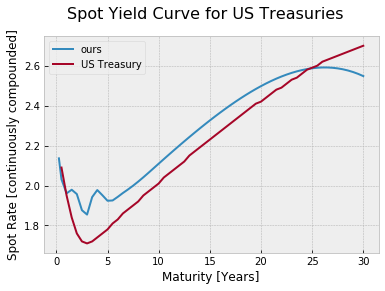

In [35]:
PlotSpotYieldCurve()

The US Treasury [[2](https://www.treasury.gov/resource-center/economic-policy/corp-bond-yield/pages/tnc-yc.aspx)] computes a Spot Yield Curve at the end of each month, alongside some explanation of their methodology [[3](https://www.treasury.gov/resource-center/economic-policy/corp-bond-yield/Documents/trp_apr2014.pdf)]. Their curve computed at the end of June is plotted alongside ours.

The two curves begin very similarly at the short-end and pass through a minimum point at around 3 years before increasing. However, our curve is less smooth around this minimum and stays around one percentage point higher for the majority of maturities.